In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.table import Table

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import chi2_contingency

from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency

from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import ttest_ind

from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning
# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [17]:
df = pd.read_excel('Dataset.xlsx')

In [18]:
df = df.drop(columns=['PropDate'])

X = df.drop('PolicyIssued', axis=1)  # Features
y = df['PolicyIssued']  # Target variable

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create new DataFrames for training and testing data
df = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


## Clean Data

In [19]:
# Get the list of columns to convert to categorical
categorical_columns = df.select_dtypes(include='int64').columns.tolist()

# Convert the selected columns to categorical
df[categorical_columns] = df[categorical_columns].astype('category')

numeric_data = df.select_dtypes(include=[np.number])

# Calculate MAD for each column
mad = numeric_data.mad()

# Choose a threshold multiplier
k = 3

# Calculate the threshold value
threshold = k * mad

# Identify outliers
outliers = (np.abs(numeric_data - numeric_data.median()) > threshold)

# Apply logarithm to the specified columns
outlier_columns = ['CommissionSacrificePercentage', 'BonusCommissionPercentage']
for column in outlier_columns:
    df[column] = np.log1p(df[column])

numeric_data = df.select_dtypes(include=[np.number])

# Check that all outliers have been handled
outliers = (np.abs(numeric_data - numeric_data.median()) > threshold)

# Count the number of outliers in each column
outlier_counts = outliers.sum()

# Create a new DataFrame from outlier_counts
outlier_table = pd.DataFrame({'Column': outlier_counts.index, 'Outlier Count': outlier_counts.values})

# Display the table
print(outlier_table)

                          Column  Outlier Count
0  CommissionSacrificePercentage              0
1      BonusCommissionPercentage              0


In [20]:
# Get the list of columns to convert to categorical
categorical_columns = df_test.select_dtypes(include='int64').columns.tolist()

# Convert the selected columns to categorical
df_test[categorical_columns] = df_test[categorical_columns].astype('category')


# Model Selection

## Imbalanced Dataset

Model: Logistic Regression
Accuracy: 0.78
Precision: 0.79
Recall: 0.97
F1 Score: 0.87
ROC AUC Score: 0.55
-------------------------
Model: Decision Tree
Accuracy: 0.76
Precision: 0.85
Recall: 0.85
F1 Score: 0.85
ROC AUC Score: 0.66
-------------------------
Model: Random Forest
Accuracy: 0.78
Precision: 0.84
Recall: 0.88
F1 Score: 0.86
ROC AUC Score: 0.65
-------------------------
Model: Gradient Boosting
Accuracy: 0.80
Precision: 0.82
Recall: 0.96
F1 Score: 0.88
ROC AUC Score: 0.60
-------------------------
Model: LightGBM
Accuracy: 0.81
Precision: 0.84
Recall: 0.93
F1 Score: 0.88
ROC AUC Score: 0.65
-------------------------


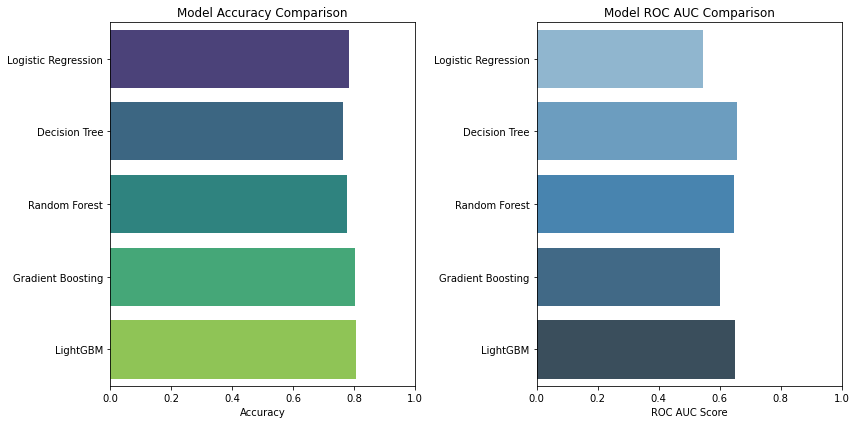

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import lightgbm as lgb

X = df.drop('PolicyIssued', axis=1)  # Features
y = df['PolicyIssued']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of models to iterate through
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "LightGBM": lgb.LGBMClassifier(),
}

# Create lists to store the model names, accuracies, and ROC AUC scores
model_names = []
accuracies = []
roc_auc_scores = []

# Loop through each model, fit it to the data, and evaluate its performance
for name, model in models.items():
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Append the results to the lists
    model_names.append(name)
    accuracies.append(accuracy)
    roc_auc_scores.append(roc_auc)
    
    # Print the results for each model
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC Score: {roc_auc:.2f}")
    print("-------------------------")

# Create subplots for model accuracy and ROC AUC visualisations
plt.figure(figsize=(12, 6))

# Model Accuracy Comparison
plt.subplot(1, 2, 1)
sns.barplot(x=accuracies, y=model_names, palette="viridis")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xlim(0, 1.0)  # Set the x-axis limits to accommodate accuracy values

# Model ROC AUC Comparison
plt.subplot(1, 2, 2)
sns.barplot(x=roc_auc_scores, y=model_names, palette="Blues_d")
plt.xlabel("ROC AUC Score")
plt.title("Model ROC AUC Comparison")
plt.xlim(0, 1.0)  # Set the x-axis limits to accommodate ROC AUC values

plt.tight_layout()  
plt.show()


### Hyperparameter Tuning

In [6]:
import numpy as np
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for each model
param_grids = {
    "Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 10],
        "penalty": ["l1", "l2"]
    },
    "Decision Tree": {
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10]
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 4, 5],
        "learning_rate": [0.01, 0.1, 0.2]
    },
    "LightGBM": {
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 4, 5],
        "learning_rate": [0.01, 0.1, 0.2]
    },
}

# Create lists to store the model names, accuracies, and ROC AUC scores
model_names = []
accuracies = []
roc_auc_scores = []

# Create dictionaries to store the best hyperparameters and best models
best_hyperparameters = {}
best_models = {}

# Loop through each model and perform hyperparameter tuning
for name, model in models.items():
    # Define the hyperparameter grid for the current model
    param_grid = param_grids.get(name, {})  # Get the hyperparameter grid or an empty dictionary
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    
    # Fit the model to the data with hyperparameter tuning
    grid_search.fit(X_train, y_train)
    
    # Get the best hyperparameters
    best_hyperparameters[name] = grid_search.best_params_
    
    # Get the best model with tuned hyperparameters
    best_model = grid_search.best_estimator_
    
    # Store the best model in the dictionary
    best_models[name] = best_model
    
    # Print the results for each set of hyperparameters
    print(f"Model: {name}")
    print("Hyperparameters and Cross-Validation Scores:")
    for params, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
        print(f"Hyperparameters: {params}")
        print(f"Mean CV Score: {score:.2f}")
    
    # Evaluate the best model's performance
    y_pred = best_model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Append the results to the lists
    model_names.append(name)
    accuracies.append(accuracy)
    roc_auc_scores.append(roc_auc)
    
    # Print the results for the best model
    print(f"Best Hyperparameters: {best_hyperparameters[name]}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC Score: {roc_auc:.2f}")
    print("-------------------------")


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gregl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gregl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\gregl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Valu

Model: Logistic Regression
Hyperparameters and Cross-Validation Scores:
Hyperparameters: {'C': 0.001, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 0.001, 'penalty': 'l2'}
Mean CV Score: 0.79
Hyperparameters: {'C': 0.01, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 0.01, 'penalty': 'l2'}
Mean CV Score: 0.79
Hyperparameters: {'C': 0.1, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Mean CV Score: 0.78
Hyperparameters: {'C': 1, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 1, 'penalty': 'l2'}
Mean CV Score: 0.79
Hyperparameters: {'C': 10, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 10, 'penalty': 'l2'}
Mean CV Score: 0.79
Best Hyperparameters: {'C': 10, 'penalty': 'l2'}
Accuracy: 0.78
Precision: 0.79
Recall: 0.98
F1 Score: 0.88
ROC AUC Score: 0.54
-------------------------
Model: Decision Tree
Hyperparameters and Cross-Validation Scores:
Hyperparameters: {'max_depth': None, 'min_samples_split': 2}
Me

Model: LightGBM
Hyperparameters and Cross-Validation Scores:
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Mean CV Score: 0.81
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Mean CV Score: 0.81
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Mean CV Score: 0.82
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
Mean CV Score: 0.81
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
Mean CV Score: 0.82
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
Mean CV Score: 0.82
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Mean CV Score: 0.81
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Mean CV Score: 0.82
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
Mean CV Score: 0.82
Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, '

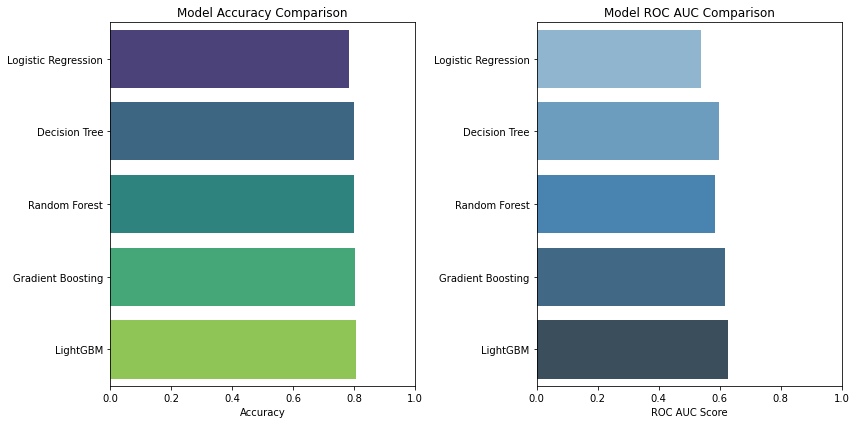

In [7]:
# Create subplots for model accuracy and ROC AUC visualizations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=accuracies, y=model_names, palette="viridis")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xlim(0, 1.0)

plt.subplot(1, 2, 2)
sns.barplot(x=roc_auc_scores, y=model_names, palette="Blues_d")
plt.xlabel("ROC AUC Score")
plt.title("Model ROC AUC Comparison")
plt.xlim(0, 1.0)

plt.tight_layout()
plt.show()


In [8]:
# Print and visualise the best models
for name, best_model in best_models.items():
    print(f"Best Model: {name}")
    print("Best Hyperparameters:", best_hyperparameters[name])
    
    # Evaluate the best model's performance
    y_pred = best_model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Print the results for the best model
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC Score: {roc_auc:.2f}")
    print("-------------------------")
    

Best Model: Logistic Regression
Best Hyperparameters: {'C': 10, 'penalty': 'l2'}
Accuracy: 0.78
Precision: 0.79
Recall: 0.98
F1 Score: 0.88
ROC AUC Score: 0.54
-------------------------
Best Model: Decision Tree
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10}
Accuracy: 0.80
Precision: 0.81
Recall: 0.96
F1 Score: 0.88
ROC AUC Score: 0.60
-------------------------
Best Model: Random Forest
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.80
Precision: 0.81
Recall: 0.97
F1 Score: 0.88
ROC AUC Score: 0.58
-------------------------
Best Model: Gradient Boosting
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
Accuracy: 0.80
Precision: 0.82
Recall: 0.95
F1 Score: 0.88
ROC AUC Score: 0.62
-------------------------
Best Model: LightGBM
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.81
Precision: 0.83
Recall: 0.95
F1 Score: 0.88
ROC AUC Score: 0.63
--

## Test on Unseen Data

In [100]:
X = df.drop('PolicyIssued', axis=1)  # Features
y = df['PolicyIssued']  # Target variable

# Split the data into a training set and a test set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


X_test = df_test.drop('PolicyIssued', axis=1)  # Features
y_test = df_test['PolicyIssued']  # Target variable


### Logistic Regression

In [98]:
# Load the trained Logistic Regression model with the best hyperparameters
best_lr_model = LogisticRegression(C=10, penalty='l2')

# Fit the model to training data
best_lr_model.fit(X_train, y_train)

# Make predictions on the unseen data
lr_predictions = best_lr_model.predict_proba(X_test)

# Calculate ROC AUC
lr_roc_auc = roc_auc_score(y_test, lr_predictions[:, 1])

# Calculate accuracy
lr_accuracy = accuracy_score(y_test, lr_predictions.argmax(axis=1))

# Calculate precision
lr_precision = precision_score(y_test, lr_predictions.argmax(axis=1))

# Calculate recall
lr_recall = recall_score(y_test, lr_predictions.argmax(axis=1))

# Calculate F1 score
lr_f1 = f1_score(y_test, lr_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", lr_roc_auc)
print("Accuracy:", lr_accuracy)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1 Score:", lr_f1)


ROC AUC: 0.7715900657606003
Accuracy: 0.7559533271865959
Precision: 0.8281329324012965
Recall: 0.8662227850169519
F1 Score: 0.8467497204919342


### Decision Tree

In [84]:
# Load the trained Decision Tree model with the best hyperparameters
best_dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=10)

# Fit the model to training data
best_dt_model.fit(X_train, y_train)

# Make predictions on the unseen data
dt_predictions = best_dt_model.predict_proba(X_test)

# Create a DataFrame with the predictions for further analysis if needed
dt_predictions_df = pd.DataFrame({'Probability_Conversion': dt_predictions[:, 1]})

# Calculate ROC AUC
dt_roc_auc = roc_auc_score(y_test, dt_predictions[:, 1])

# Calculate accuracy
dt_accuracy = accuracy_score(y_test, dt_predictions.argmax(axis=1))

# Calculate precision
dt_precision = precision_score(y_test, dt_predictions.argmax(axis=1))

# Calculate recall
dt_recall = recall_score(y_test, dt_predictions.argmax(axis=1))

# Calculate F1 score
dt_f1 = f1_score(y_test, dt_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", dt_roc_auc)
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1 Score:", dt_f1)


ROC AUC: 0.7848208996624193
Accuracy: 0.7743617460973516
Precision: 0.8285455095252495
Recall: 0.8953882602834852
F1 Score: 0.8606710249916565


### Random Forest

In [85]:
# Load the trained Random Forest model with the best hyperparameters
best_rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10)

# Fit the model to training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the unseen data
rf_predictions = best_rf_model.predict_proba(X_test)

# Create a DataFrame with the predictions for further analysis if needed
rf_predictions_df = pd.DataFrame({'Probability_Conversion': rf_predictions[:, 1]})

# Calculate ROC AUC
rf_roc_auc = roc_auc_score(y_test, rf_predictions[:, 1])

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions.argmax(axis=1))

# Calculate precision
rf_precision = precision_score(y_test, rf_predictions.argmax(axis=1))

# Calculate recall
rf_recall = recall_score(y_test, rf_predictions.argmax(axis=1))

# Calculate F1 score
rf_f1 = f1_score(y_test, rf_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", rf_roc_auc)
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)


ROC AUC: 0.8018000271991934
Accuracy: 0.792929132356214
Precision: 0.8188981967911402
Recall: 0.9423634655447082
F1 Score: 0.8763033445387728


### Gradient Boosting Classifier

In [86]:
# Load the trained Gradient Boosting Classifier model with the best hyperparameters
best_gb_model = GradientBoostingClassifier(n_estimators=300, max_depth=4, learning_rate=0.1)

# Fit the model to training data
best_gb_model.fit(X_train, y_train)

# Make predictions on the unseen data
gb_predictions = best_gb_model.predict_proba(X_test)

# Create a DataFrame with the predictions for further analysis if needed
gb_predictions_df = pd.DataFrame({'Probability_Conversion': gb_predictions[:, 1]})

# Calculate ROC AUC
gb_roc_auc = roc_auc_score(y_test, gb_predictions[:, 1])

# Calculate accuracy
gb_accuracy = accuracy_score(y_test, gb_predictions.argmax(axis=1))

# Calculate precision
gb_precision = precision_score(y_test, gb_predictions.argmax(axis=1))

# Calculate recall
gb_recall = recall_score(y_test, gb_predictions.argmax(axis=1))

# Calculate F1 score
gb_f1 = f1_score(y_test, gb_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", gb_roc_auc)
print("Accuracy:", gb_accuracy)
print("Precision:", gb_precision)
print("Recall:", gb_recall)
print("F1 Score:", gb_f1)


ROC AUC: 0.7848228799586825
Accuracy: 0.7924204368422726
Precision: 0.8324937027707808
Recall: 0.9180180548180221
F1 Score: 0.8731666569535909


### LightGBM

In [87]:
# Load the trained LightGBM model with the best hyperparameters
best_lightgbm_model = lgb.LGBMClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)

# Fit the model to your training data (assuming you have already trained it)
best_lightgbm_model.fit(X_train, y_train)

# Make predictions on the unseen data
lgb_predictions = best_lightgbm_model.predict_proba(X_test)

# Create a DataFrame with the predictions for further analysis if needed
lgb_predictions_df = pd.DataFrame({'Probability_Conversion': lgb_predictions[:, 1]})

# Calculate ROC AUC
lgb_roc_auc = roc_auc_score(y_test, lgb_predictions[:, 1])

# Calculate accuracy
lgb_accuracy = accuracy_score(y_test, lgb_predictions.argmax(axis=1))

# Calculate precision
lgb_precision = precision_score(y_test, lgb_predictions.argmax(axis=1))

# Calculate recall
lgb_recall = recall_score(y_test, lgb_predictions.argmax(axis=1))

# Calculate F1 score
lgb_f1 = f1_score(y_test, lgb_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", lgb_roc_auc)
print("Accuracy:", lgb_accuracy)
print("Precision:", lgb_precision)
print("Recall:",lgb_recall)
print("F1 Score:", lgb_f1)


ROC AUC: 0.8245078618113176
Accuracy: 0.8078720630782438
Precision: 0.8322162162162162
Recall: 0.9433438176545076
F1 Score: 0.8843024257624782


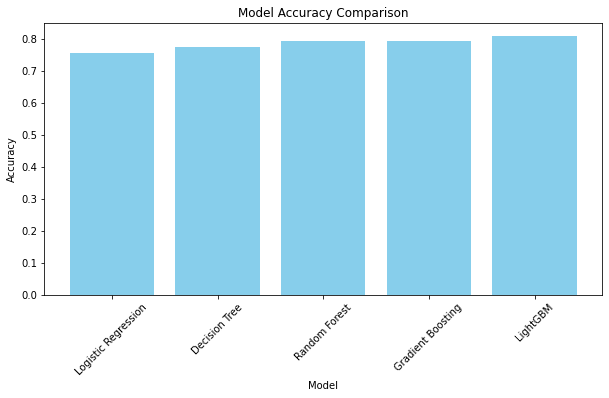

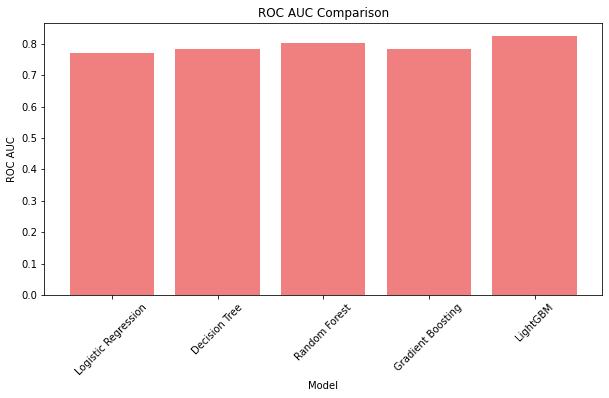

In [88]:
import matplotlib.pyplot as plt

model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "Gradient Boosting", "LightGBM"]
accuracies = [lr_accuracy, dt_accuracy, rf_accuracy, gb_accuracy, lgb_accuracy]
roc_auc_scores = [lr_roc_auc, dt_roc_auc, rf_roc_auc, gb_roc_auc, lgb_roc_auc]

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

# Plot ROC AUC
plt.figure(figsize=(10, 5))
plt.bar(model_names, roc_auc_scores, color='lightcoral')
plt.xlabel('Model')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Comparison')
plt.xticks(rotation=45)
plt.show()


## Using Most Important Features Only

### Logistic Regression

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gregl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gregl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\gregl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Valu

Model: Logistic Regression
Hyperparameters and Cross-Validation Scores:
Hyperparameters: {'C': 0.001, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 0.001, 'penalty': 'l2'}
Mean CV Score: 0.79
Hyperparameters: {'C': 0.01, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 0.01, 'penalty': 'l2'}
Mean CV Score: 0.79
Hyperparameters: {'C': 0.1, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Mean CV Score: 0.79
Hyperparameters: {'C': 1, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 1, 'penalty': 'l2'}
Mean CV Score: 0.79
Hyperparameters: {'C': 10, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 10, 'penalty': 'l2'}
Mean CV Score: 0.79
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.78
Precision: 0.80
Recall: 0.97
F1 Score: 0.87
ROC AUC Score: 0.55
-------------------------


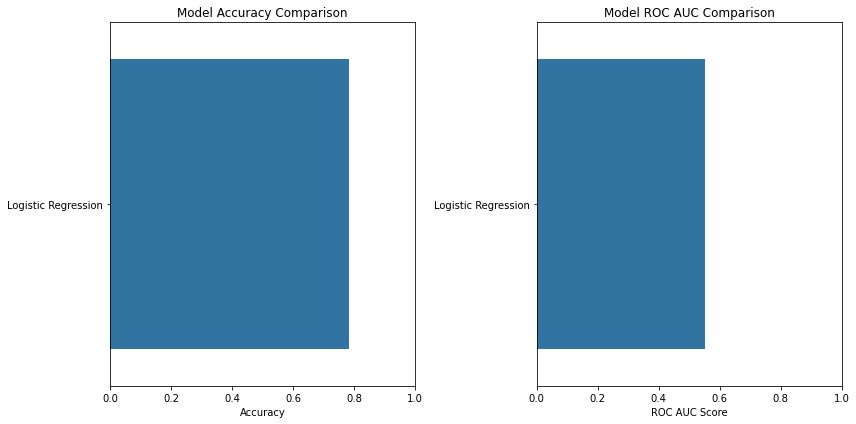

Best Model: Logistic Regression
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.78
Precision: 0.80
Recall: 0.97
F1 Score: 0.87
ROC AUC Score: 0.55
-------------------------


In [29]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Load your DataFrame 'df' with your data

# Select predictor variables
X = df[['Agency', 'WorkflowStatus', 'Product', 'ProductGroup', 'ProductType',
        'UWDecision', 'CommDateProvided', 'SignedDecReceived',
        'Indexation', 'NoOfLives', 'ComissionSacrifice',
        'CommissionSacrificePercentage', 'CommissionTerms', 'BonusCommissionPercentage',
        'SignedDecReceived']]
y = df['PolicyIssued']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for logistic regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Create lists to store the model names, accuracies, and ROC AUC scores
model_names = []
accuracies = []
roc_auc_scores = []

# Create dictionaries to store the best hyperparameters and best models
best_hyperparameters = {}
best_models = {}

# Create a Logistic Regression model
logistic_regression_model = LogisticRegression()

# Loop through Logistic Regression models and perform hyperparameter tuning
model_name = "Logistic Regression"
model = logistic_regression_model

# Create GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')

# Fit the model to the data with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_hyperparameters[model_name] = grid_search.best_params_

# Get the best model with tuned hyperparameters
best_model = grid_search.best_estimator_

# Store the best model in the dictionary
best_models[model_name] = best_model

# Print the results for each set of hyperparameters
print(f"Model: {model_name}")
print("Hyperparameters and Cross-Validation Scores:")
for params, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    print(f"Hyperparameters: {params}")
    print(f"Mean CV Score: {score:.2f}")

# Evaluate the best model's performance
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Append the results to the lists
model_names.append(model_name)
accuracies.append(accuracy)
roc_auc_scores.append(roc_auc)

# Print the results for the best model
print(f"Best Hyperparameters: {best_hyperparameters[model_name]}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("-------------------------")

# Create subplots for model accuracy and ROC AUC visualizations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

# Check if accuracies and model_names are not empty before creating the barplot
if accuracies and model_names:
    sns.barplot(x=accuracies, y=model_names)
    plt.xlabel("Accuracy")
    plt.title("Model Accuracy Comparison")
    plt.xlim(0, 1.0)
else:
    print("No data to plot for accuracy.")

plt.subplot(1, 2, 2)

# Check if roc_auc_scores and model_names are not empty before creating the barplot
if roc_auc_scores and model_names:
    sns.barplot(x=roc_auc_scores, y=model_names)
    plt.xlabel("ROC AUC Score")
    plt.title("Model ROC AUC Comparison")
    plt.xlim(0, 1.0)
else:
    print("No data to plot for ROC AUC.")

plt.tight_layout()
plt.show()

# Print and visualize the best models
for name, best_model in best_models.items():
    print(f"Best Model: {name}")
    print("Best Hyperparameters:", best_hyperparameters[name])

    # Evaluate the best model's performance
    y_pred = best_model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Print the results for the best model
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC Score: {roc_auc:.2f}")
    print("-------------------------")


In [107]:
# Select predictor variables
X = df[['Agency', 'WorkflowStatus', 'Product', 'ProductGroup', 'ProductType',
        'UWDecision', 'CommDateProvided', 'SignedDecReceived',
        'Indexation', 'NoOfLives', 'ComissionSacrifice',
        'CommissionSacrificePercentage', 'CommissionTerms', 'BonusCommissionPercentage',
        'SignedDecReceived']]
y = df['PolicyIssued']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test[['Agency', 'WorkflowStatus', 'Product', 'ProductGroup', 'ProductType',
        'UWDecision', 'CommDateProvided', 'SignedDecReceived',
        'Indexation', 'NoOfLives', 'ComissionSacrifice',
        'CommissionSacrificePercentage', 'CommissionTerms', 'BonusCommissionPercentage',
        'SignedDecReceived']]
y_test = df_test['PolicyIssued']

# Load the trained Logistic Regression model with the best hyperparameters
best_lr_model = LogisticRegression(C=0.1, penalty='l2')

# Fit the model to training data
best_lr_model.fit(X_train, y_train)

# Make predictions on the unseen data
lr_predictions = best_lr_model.predict_proba(X_test)

# Calculate ROC AUC
lr_roc_auc = roc_auc_score(y_test, lr_predictions[:, 1])

# Calculate accuracy
lr_accuracy = accuracy_score(y_test, lr_predictions.argmax(axis=1))

# Calculate precision
lr_precision = precision_score(y_test, lr_predictions.argmax(axis=1))

# Calculate recall
lr_recall = recall_score(y_test, lr_predictions.argmax(axis=1))

# Calculate F1 score
lr_f1 = f1_score(y_test, lr_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", lr_roc_auc)
print("Accuracy:", lr_accuracy)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1 Score:", lr_f1)


ROC AUC: 0.718443650951059
Accuracy: 0.6916987250818681
Precision: 0.8309159280150417
Recall: 0.758179812916139
F1 Score: 0.7928832311668339


### Decision Tree & Random Forest

#### 'Agency', 'WorkflowStatus'

Model: Decision Tree
Hyperparameters and Cross-Validation Scores:
Hyperparameters: {'max_depth': None, 'min_samples_split': 2}
Mean CV Score: 0.80
Hyperparameters: {'max_depth': None, 'min_samples_split': 5}
Mean CV Score: 0.80
Hyperparameters: {'max_depth': None, 'min_samples_split': 10}
Mean CV Score: 0.80
Hyperparameters: {'max_depth': 10, 'min_samples_split': 2}
Mean CV Score: 0.80
Hyperparameters: {'max_depth': 10, 'min_samples_split': 5}
Mean CV Score: 0.80
Hyperparameters: {'max_depth': 10, 'min_samples_split': 10}
Mean CV Score: 0.80
Hyperparameters: {'max_depth': 20, 'min_samples_split': 2}
Mean CV Score: 0.80
Hyperparameters: {'max_depth': 20, 'min_samples_split': 5}
Mean CV Score: 0.80
Hyperparameters: {'max_depth': 20, 'min_samples_split': 10}
Mean CV Score: 0.80
Hyperparameters: {'max_depth': 30, 'min_samples_split': 2}
Mean CV Score: 0.80
Hyperparameters: {'max_depth': 30, 'min_samples_split': 5}
Mean CV Score: 0.80
Hyperparameters: {'max_depth': 30, 'min_samples_split': 

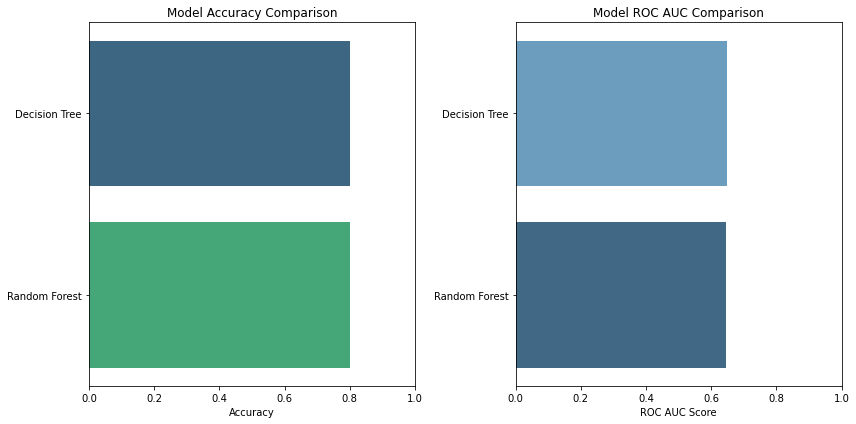

Best Model: Decision Tree
Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 10}
Accuracy: 0.80
Precision: 0.84
Recall: 0.92
F1 Score: 0.88
ROC AUC Score: 0.65
-------------------------
Best Model: Random Forest
Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.80
Precision: 0.84
Recall: 0.93
F1 Score: 0.88
ROC AUC Score: 0.65
-------------------------


In [10]:
# Select predictor variables
X = df[['Agency', 'WorkflowStatus']]
y = df['PolicyIssued']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grids for Decision Tree and Random Forest
param_grids = {
    "Decision Tree": {
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10]
    },
}

# Create lists to store the model names, accuracies, and ROC AUC scores
model_names = []
accuracies = []
roc_auc_scores = []

# Create dictionaries to store the best hyperparameters and best models
best_hyperparameters = {}
best_models = {}

# Loop through Decision Tree and Random Forest models and perform hyperparameter tuning
for name, param_grid in param_grids.items():
    if name in ["Decision Tree", "Random Forest"]:
        if name == "Decision Tree":
            model = DecisionTreeClassifier()
        elif name == "Random Forest":
            model = RandomForestClassifier()

        # Create GridSearchCV object
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')

        # Fit the model to the data with hyperparameter tuning
        grid_search.fit(X_train, y_train)

        # Get the best hyperparameters
        best_hyperparameters[name] = grid_search.best_params_

        # Get the best model with tuned hyperparameters
        best_model = grid_search.best_estimator_

        # Store the best model in the dictionary
        best_models[name] = best_model

        # Print the results for each set of hyperparameters
        print(f"Model: {name}")
        print("Hyperparameters and Cross-Validation Scores:")
        for params, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
            print(f"Hyperparameters: {params}")
            print(f"Mean CV Score: {score:.2f}")

        # Evaluate the best model's performance
        y_pred = best_model.predict(X_test)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)

        # Append the results to the lists
        model_names.append(name)
        accuracies.append(accuracy)
        roc_auc_scores.append(roc_auc)

        # Print the results for the best model
        print(f"Best Hyperparameters: {best_hyperparameters[name]}")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")
        print(f"ROC AUC Score: {roc_auc:.2f}")
        print("-------------------------")

# Create subplots for model accuracy and ROC AUC visualisations (same code as before)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=accuracies, y=model_names, palette="viridis")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xlim(0, 1.0)

plt.subplot(1, 2, 2)
sns.barplot(x=roc_auc_scores, y=model_names, palette="Blues_d")
plt.xlabel("ROC AUC Score")
plt.title("Model ROC AUC Comparison")
plt.xlim(0, 1.0)

plt.tight_layout()
plt.show()

# Print and visualize the best models
for name, best_model in best_models.items():
    print(f"Best Model: {name}")
    print("Best Hyperparameters:", best_hyperparameters[name])

    # Evaluate the best model's performance
    y_pred = best_model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Print the results for the best model
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC Score: {roc_auc:.2f}")
    print("-------------------------")


In [112]:
# Select predictor variables
X = df[['Agency', 'WorkflowStatus']]
y = df['PolicyIssued']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test[['Agency', 'WorkflowStatus']]
y_test = df_test['PolicyIssued']

# Load the trained Logistic Regression model with the best hyperparameters
best_dt_model = DecisionTreeClassifier(max_depth=20, min_samples_split=10)

# Fit the model to training data
best_dt_model.fit(X_train, y_train)

# Make predictions on the unseen data
dt_predictions = best_dt_model.predict_proba(X_test)

# Create a DataFrame with the predictions for further analysis if needed
dt_predictions_df = pd.DataFrame({'Probability_Conversion': dt_predictions[:, 1]})

# Calculate ROC AUC
dt_roc_auc = roc_auc_score(y_test, dt_predictions[:, 1])

# Calculate accuracy
dt_accuracy = accuracy_score(y_test, dt_predictions.argmax(axis=1))

# Calculate precision
dt_precision = precision_score(y_test, dt_predictions.argmax(axis=1))

# Calculate recall
dt_recall = recall_score(y_test, dt_predictions.argmax(axis=1))

# Calculate F1 score
dt_f1 = f1_score(y_test, dt_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", dt_roc_auc)
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1 Score:", dt_f1)


ROC AUC: 0.8061729754101339
Accuracy: 0.7999236956729088
Precision: 0.8368647206993629
Recall: 0.9228381193578694
F1 Score: 0.8777512287040815


In [113]:
# Select predictor variables
X = df[['Agency', 'WorkflowStatus']]
y = df['PolicyIssued']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test[['Agency', 'WorkflowStatus']]
y_test = df_test['PolicyIssued']

# Load the trained Random Forest model with the best hyperparameters
best_rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10)

# Fit the model to training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the unseen data
rf_predictions = best_rf_model.predict_proba(X_test)

# Create a DataFrame with the predictions for further analysis if needed
rf_predictions_df = pd.DataFrame({'Probability_Conversion': rf_predictions[:, 1]})

# Calculate ROC AUC
rf_roc_auc = roc_auc_score(y_test, rf_predictions[:, 1])

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions.argmax(axis=1))

# Calculate precision
rf_precision = precision_score(y_test, rf_predictions.argmax(axis=1))

# Calculate recall
rf_recall = recall_score(y_test, rf_predictions.argmax(axis=1))

# Calculate F1 score
rf_f1 = f1_score(y_test, rf_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", rf_roc_auc)
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)


ROC AUC: 0.8096685703524152
Accuracy: 0.8006549454741996
Precision: 0.8338405132905591
Recall: 0.9290061680486909
F1 Score: 0.8788546255506607


### Gradient Boosting Classifier

Hyperparameters and Cross-Validation Scores:
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Mean CV Score: 0.80
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Mean CV Score: 0.80
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Mean CV Score: 0.81
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
Mean CV Score: 0.80
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
Mean CV Score: 0.81
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
Mean CV Score: 0.81
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Mean CV Score: 0.81
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Mean CV Score: 0.81
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
Mean CV Score: 0.81
Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1

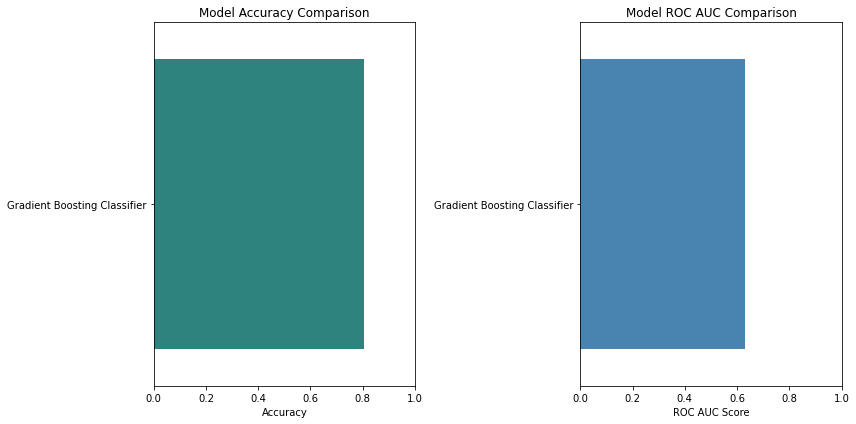

In [5]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Select predictor variables
X = df[['WorkflowStatus', 'Agency', 'UWDecision', 'ProductGroup'
                     , 'CommDateProvided', 'Product', 'BonusCommission', 'NoOfLives'
                     , 'ProductType', 'SignedDecReceived', 'Indexation']]
y = df['PolicyIssued']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for Gradient Boosting Classifier
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5],
}

# Create a GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(gb_classifier, param_grid, cv=5, scoring='roc_auc')

# Fit the model to the data with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_hyperparameters = grid_search.best_params_

# Get the best model with tuned hyperparameters
best_model = grid_search.best_estimator_

# Print the results for each set of hyperparameters
print("Hyperparameters and Cross-Validation Scores:")
for params, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    print(f"Hyperparameters: {params}")
    print(f"Mean CV Score: {score:.2f}")

# Evaluate the best model's performance
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the results for the best model
print("Best Hyperparameters:", best_hyperparameters)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

# Create subplots for model accuracy and ROC AUC visualizations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=[accuracy], y=["Gradient Boosting Classifier"], palette="viridis")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xlim(0, 1.0)

plt.subplot(1, 2, 2)
sns.barplot(x=[roc_auc], y=["Gradient Boosting Classifier"], palette="Blues_d")
plt.xlabel("ROC AUC Score")
plt.title("Model ROC AUC Comparison")
plt.xlim(0, 1.0)

plt.tight_layout()
plt.show()


In [114]:
# Select predictor variables
X = df[['Agency', 'WorkflowStatus']]
y = df['PolicyIssued']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test[['Agency', 'WorkflowStatus']]
y_test = df_test['PolicyIssued']

# Load the trained Gradient Boosting Classifier model with the best hyperparameters
best_gb_model = GradientBoostingClassifier(n_estimators=300, max_depth=4, learning_rate=0.2)

# Fit the model to training data
best_gb_model.fit(X_train, y_train)

# Make predictions on the unseen data
gb_predictions = best_gb_model.predict_proba(X_test)

# Create a DataFrame with the predictions for further analysis if needed
gb_predictions_df = pd.DataFrame({'Probability_Conversion': gb_predictions[:, 1]})

# Calculate ROC AUC
gb_roc_auc = roc_auc_score(y_test, gb_predictions[:, 1])

# Calculate accuracy
gb_accuracy = accuracy_score(y_test, gb_predictions.argmax(axis=1))

# Calculate precision
gb_precision = precision_score(y_test, gb_predictions.argmax(axis=1))

# Calculate recall
gb_recall = recall_score(y_test, gb_predictions.argmax(axis=1))

# Calculate F1 score
gb_f1 = f1_score(y_test, gb_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", gb_roc_auc)
print("Accuracy:", gb_accuracy)
print("Precision:", gb_precision)
print("Recall:", gb_recall)
print("F1 Score:", gb_f1)


ROC AUC: 0.8106840522148583
Accuracy: 0.8015133691539758
Precision: 0.8259113652609007
Recall: 0.9439565377231323
F1 Score: 0.8809973122891291


### LightGBM

Hyperparameters and Cross-Validation Scores:
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Mean CV Score: 0.81
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Mean CV Score: 0.81
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Mean CV Score: 0.82
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
Mean CV Score: 0.81
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
Mean CV Score: 0.81
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
Mean CV Score: 0.82
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Mean CV Score: 0.81
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Mean CV Score: 0.82
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
Mean CV Score: 0.82
Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1

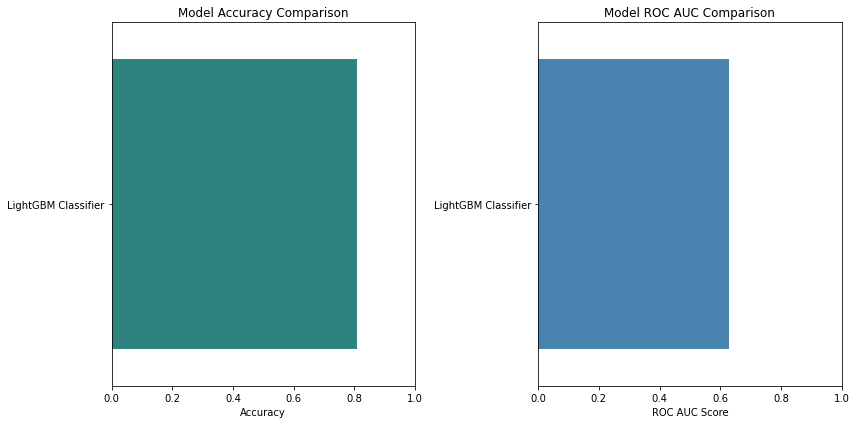

In [7]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Select predictor variables
X = df[['Agency', 'UWDecision', 'CommDateProvided', 'SignedDecReceived'
                     , 'ProductType', 'WorkflowStatus', 'NoOfLives', 'ProductGroup'
                     , 'BonusCommission', 'Product', 'SeriousIllnessType']]
y = df['PolicyIssued']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for LightGBM
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5],
}

# Create a LightGBM classifier
lgbm_classifier = LGBMClassifier(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(lgbm_classifier, param_grid, cv=5, scoring='roc_auc')

# Fit the model to the data with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_hyperparameters = grid_search.best_params_

# Get the best model with tuned hyperparameters
best_model = grid_search.best_estimator_

# Print the results for each set of hyperparameters
print("Hyperparameters and Cross-Validation Scores:")
for params, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    print(f"Hyperparameters: {params}")
    print(f"Mean CV Score: {score:.2f}")

# Evaluate the best model's performance
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the results for the best model
print("Best Hyperparameters:", best_hyperparameters)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

# Create subplots for model accuracy and ROC AUC visualizations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=[accuracy], y=["LightGBM Classifier"], palette="viridis")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xlim(0, 1.0)

plt.subplot(1, 2, 2)
sns.barplot(x=[roc_auc], y=["LightGBM Classifier"], palette="Blues_d")
plt.xlabel("ROC AUC Score")
plt.title("Model ROC AUC Comparison")
plt.xlim(0, 1.0)

plt.tight_layout()
plt.show()


In [115]:
# Select predictor variables
X = df[['Agency', 'WorkflowStatus']]
y = df['PolicyIssued']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test[['Agency', 'WorkflowStatus']]
y_test = df_test['PolicyIssued']

# Load the trained LightGBM model with the best hyperparameters
best_lightgbm_model = lgb.LGBMClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)

# Fit the model to your training data (assuming you have already trained it)
best_lightgbm_model.fit(X_train, y_train)

# Make predictions on the unseen data
lgb_predictions = best_lightgbm_model.predict_proba(X_test)

# Create a DataFrame with the predictions for further analysis if needed
lgb_predictions_df = pd.DataFrame({'Probability_Conversion': lgb_predictions[:, 1]})

# Calculate ROC AUC
lgb_roc_auc = roc_auc_score(y_test, lgb_predictions[:, 1])

# Calculate accuracy
lgb_accuracy = accuracy_score(y_test, lgb_predictions.argmax(axis=1))

# Calculate precision
lgb_precision = precision_score(y_test, lgb_predictions.argmax(axis=1))

# Calculate recall
lgb_recall = recall_score(y_test, lgb_predictions.argmax(axis=1))

# Calculate F1 score
lgb_f1 = f1_score(y_test, lgb_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", lgb_roc_auc)
print("Accuracy:", lgb_accuracy)
print("Precision:", lgb_precision)
print("Recall:",lgb_recall)
print("F1 Score:", lgb_f1)

ROC AUC: 0.8118571258195644
Accuracy: 0.8028486948780721
Precision: 0.8153899240855763
Recall: 0.965238348106695
F1 Score: 0.8840089036867997


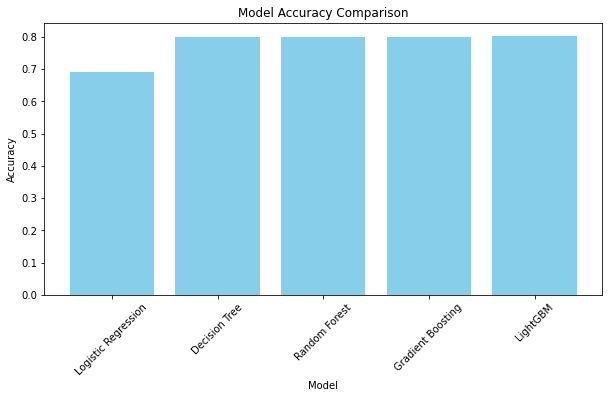

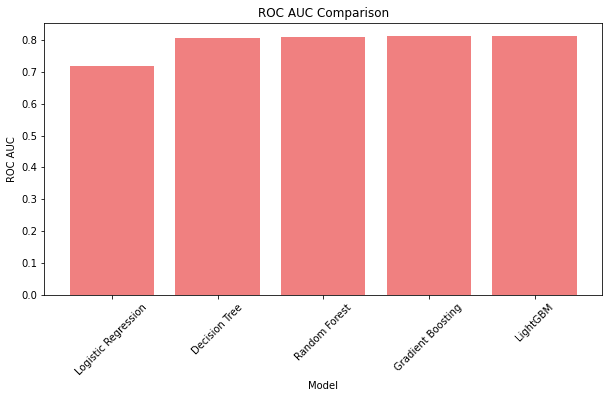

In [116]:
import matplotlib.pyplot as plt

model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "Gradient Boosting", "LightGBM"]
accuracies = [lr_accuracy, dt_accuracy, rf_accuracy, gb_accuracy, lgb_accuracy]
roc_auc_scores = [lr_roc_auc, dt_roc_auc, rf_roc_auc, gb_roc_auc, lgb_roc_auc]

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

# Plot ROC AUC
plt.figure(figsize=(10, 5))
plt.bar(model_names, roc_auc_scores, color='lightcoral')
plt.xlabel('Model')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Comparison')
plt.xticks(rotation=45)
plt.show()


# Oversampled Dataset

Model: Logistic Regression
Accuracy: 0.25
Precision: 0.87
Recall: 0.04
F1 Score: 0.08
ROC AUC Score: 0.51
-------------------------
Model: Decision Tree
Accuracy: 0.69
Precision: 0.79
Recall: 0.83
F1 Score: 0.81
ROC AUC Score: 0.52
-------------------------


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Random Forest
Accuracy: 0.22
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
ROC AUC Score: 0.50
-------------------------


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Gradient Boosting
Accuracy: 0.22
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
ROC AUC Score: 0.50
-------------------------


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LightGBM
Accuracy: 0.22
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
ROC AUC Score: 0.50
-------------------------


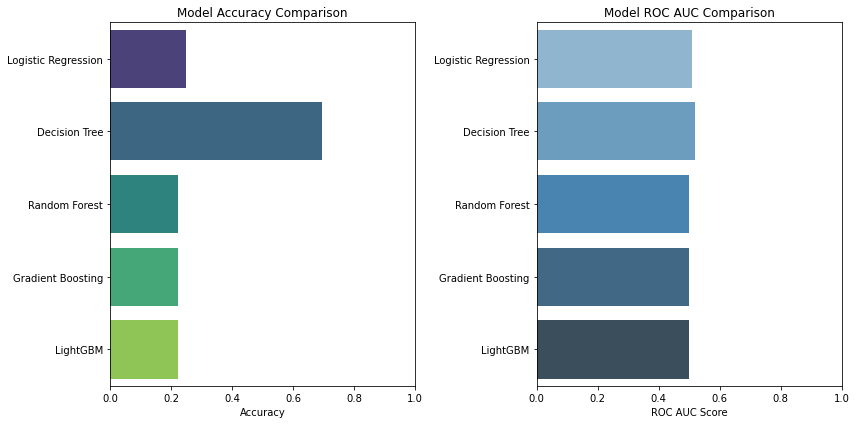

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import lightgbm as lgb
from imblearn.over_sampling import BorderlineSMOTE  # Import BorderlineSMOTE

# Define categorical columns
categorical_columns = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'NoOfLives',
            'CommDateProvided', 'PaymentFreq', 'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType',
            'RenewalSacrificeType', 'CommissionTerms', 'Discount', 'BonusCommission', 'FreeCover',
            'SeriousIllnessType', 'SignedDecReceived']

# Convert categorical columns to categorical data types
df[categorical_columns] = df[categorical_columns].astype('category')

X = df.drop('PolicyIssued', axis=1)  # Features
y = df['PolicyIssued']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Convert X_train_resampled and X_test back to Pandas DataFrames
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_train.columns)

# Reapply categorical transformation to resampled datasets
X_train_resampled[categorical_columns] = X_train_resampled[categorical_columns].astype('category')
X_test[categorical_columns] = X_test[categorical_columns].astype('category')

# Define a list of models to iterate through
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "LightGBM": lgb.LGBMClassifier(),
}

# Create lists to store the model names, accuracies, and ROC AUC scores
model_names = []
accuracies = []
roc_auc_scores = []

# Loop through each model, fit it to the oversampled data, and evaluate its performance
for name, model in models.items():
    # Fit the model to the oversampled training data
    model.fit(X_train_resampled, y_train_resampled)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Append the results to the lists
    model_names.append(name)
    accuracies.append(accuracy)
    roc_auc_scores.append(roc_auc)
    
    # Print the results for each model
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC Score: {roc_auc:.2f}")
    print("-------------------------")

# Create subplots for model accuracy and ROC AUC visualizations
plt.figure(figsize=(12, 6))

# Model Accuracy Comparison
plt.subplot(1, 2, 1)
sns.barplot(x=accuracies, y=model_names, palette="viridis")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xlim(0, 1.0)  # Set the x-axis limits to accommodate accuracy values

# Model ROC AUC Comparison
plt.subplot(1, 2, 2)
sns.barplot(x=roc_auc_scores, y=model_names, palette="Blues_d")
plt.xlabel("ROC AUC Score")
plt.title("Model ROC AUC Comparison")
plt.xlim(0, 1.0)  # Set the x-axis limits to accommodate ROC AUC values

plt.tight_layout()  
plt.show()


### Hyperparameter tuning

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gregl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gregl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\gregl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Valu

Model: Logistic Regression
Hyperparameters and Cross-Validation Scores:
Hyperparameters: {'C': 0.001, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 0.001, 'penalty': 'l2'}
Mean CV Score: 0.77
Hyperparameters: {'C': 0.01, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 0.01, 'penalty': 'l2'}
Mean CV Score: 0.77
Hyperparameters: {'C': 0.1, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Mean CV Score: 0.77
Hyperparameters: {'C': 1, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 1, 'penalty': 'l2'}
Mean CV Score: 0.77
Hyperparameters: {'C': 10, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 10, 'penalty': 'l2'}
Mean CV Score: 0.77
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.68
Precision: 0.94
Recall: 0.62
F1 Score: 0.75
ROC AUC Score: 0.75
-------------------------


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Model: Decision Tree
Hyperparameters and Cross-Validation Scores:
Hyperparameters: {'max_depth': None, 'min_samples_split': 2}
Mean CV Score: 0.79
Hyperparameters: {'max_depth': None, 'min_samples_split': 5}
Mean CV Score: 0.80
Hyperparameters: {'max_depth': None, 'min_samples_split': 10}
Mean CV Score: 0.81
Hyperparameters: {'max_depth': 10, 'min_samples_split': 2}
Mean CV Score: 0.79
Hyperparameters: {'max_depth': 10, 'min_samples_split': 5}
Mean CV Score: 0.79
Hyperparameters: {'max_depth': 10, 'min_samples_split': 10}
Mean CV Score: 0.79
Hyperparameters: {'max_depth': 20, 'min_samples_split': 2}
Mean CV Score: 0.80
Hyperparameters: {'max_depth': 20, 'min_samples_split': 5}
Mean CV Score: 0.81
Hyperparameters: {'max_depth': 20, 'min_samples_split': 10}
Mean CV Score: 0.81
Hyperparameters: {'max_depth': 30, 'min_samples_split': 2}
Mean CV Score: 0.80
Hyperparameters: {'max_depth': 30, 'min_samples_split': 5}
Mean CV Score: 0.81
Hyperparameters: {'max_depth': 30, 'min_samples_split': 

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Model: Random Forest
Hyperparameters and Cross-Validation Scores:
Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Mean CV Score: 0.85
Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Mean CV Score: 0.85
Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Mean CV Score: 0.85
Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Mean CV Score: 0.85
Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Mean CV Score: 0.85
Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Mean CV Score: 0.85
Hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Mean CV Score: 0.85
Hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Mean CV Score: 0.85
Hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}
Mean CV Score: 0.85
Hyperparamete

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Best Hyperparameters: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 300}
Accuracy: 0.72
Precision: 0.89
Recall: 0.73
F1 Score: 0.81
ROC AUC Score: 0.71
-------------------------
Model: Gradient Boosting
Hyperparameters and Cross-Validation Scores:
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Mean CV Score: 0.78
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Mean CV Score: 0.78
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Mean CV Score: 0.79
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
Mean CV Score: 0.78
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
Mean CV Score: 0.79
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
Mean CV Score: 0.79
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Mean CV Score: 0.79
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


Model: LightGBM
Hyperparameters and Cross-Validation Scores:
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Mean CV Score: 0.80
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Mean CV Score: 0.82
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Mean CV Score: 0.83
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
Mean CV Score: 0.81
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
Mean CV Score: 0.83
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
Mean CV Score: 0.84
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Mean CV Score: 0.82
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Mean CV Score: 0.83
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
Mean CV Score: 0.84
Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, '

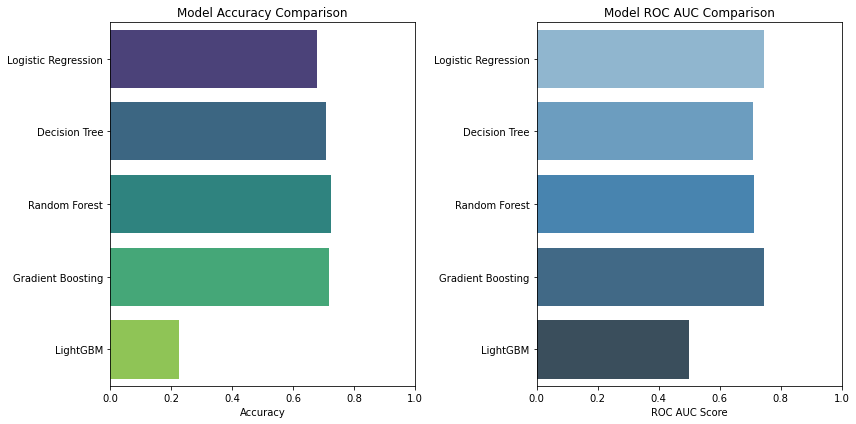

In [14]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
from imblearn.over_sampling import BorderlineSMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import lightgbm as lgb

# Define categorical columns
categorical_columns = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'NoOfLives',
            'CommDateProvided', 'PaymentFreq', 'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType',
            'RenewalSacrificeType', 'CommissionTerms', 'Discount', 'BonusCommission', 'FreeCover',
            'SeriousIllnessType', 'SignedDecReceived']

# Convert categorical columns to categorical data types
df[categorical_columns] = df[categorical_columns].astype('category')

X = df.drop('PolicyIssued', axis=1)  # Features
y = df['PolicyIssued']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Convert X_train_resampled and X_test back to Pandas DataFrames
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_train.columns)

# Reapply categorical transformation to resampled datasets
X_train_resampled[categorical_columns] = X_train_resampled[categorical_columns].astype('category')
X_test[categorical_columns] = X_test[categorical_columns].astype('category')

# Define hyperparameter grids for each model
param_grids = {
    "Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 10],
        "penalty": ["l1", "l2"]
    },
    "Decision Tree": {
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10]
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 4, 5],
        "learning_rate": [0.01, 0.1, 0.2]
    },
    "LightGBM": {
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 4, 5],
        "learning_rate": [0.01, 0.1, 0.2]
    },
}

# Create lists to store the model names, accuracies, and ROC AUC scores
model_names = []
accuracies = []
roc_auc_scores = []

# Create dictionaries to store the best hyperparameters and best models
best_hyperparameters = {}
best_models = {}

# Loop through each model and perform hyperparameter tuning
for name, model in models.items():
    # Define the hyperparameter grid for the current model
    param_grid = param_grids.get(name, {})  # Get the hyperparameter grid or an empty dictionary
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    
    # Fit the model to the data with hyperparameter tuning
    grid_search.fit(X_train_resampled, y_train_resampled)  # Use the resampled data
    
    # Get the best hyperparameters
    best_hyperparameters[name] = grid_search.best_params_
    
    # Get the best model with tuned hyperparameters
    best_model = grid_search.best_estimator_
    
    # Store the best model in the dictionary
    best_models[name] = best_model
    
    # Print the results for each set of hyperparameters
    print(f"Model: {name}")
    print("Hyperparameters and Cross-Validation Scores:")
    for params, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
        print(f"Hyperparameters: {params}")
        print(f"Mean CV Score: {score:.2f}")
    
    # Evaluate the best model's performance
    y_pred = best_model.predict(X_test_scaled)  # Use the scaled test data
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Append the results to the lists
    model_names.append(name)
    accuracies.append(accuracy)
    roc_auc_scores.append(roc_auc)
    
    # Print the results for the best model
    print(f"Best Hyperparameters: {best_hyperparameters[name]}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC Score: {roc_auc:.2f}")
    print("-------------------------")

# Create subplots for model accuracy and ROC AUC visualizations
plt.figure(figsize=(12, 6))

# Model Accuracy Comparison
plt.subplot(1, 2, 1)
sns.barplot(x=accuracies, y=model_names, palette="viridis")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xlim(0, 1.0)  # Set the x-axis limits to accommodate accuracy values

# Model ROC AUC Comparison
plt.subplot(1, 2, 2)
sns.barplot(x=roc_auc_scores, y=model_names, palette="Blues_d")
plt.xlabel("ROC AUC Score")
plt.title("Model ROC AUC Comparison")
plt.xlim(0, 1.0)  # Set the x-axis limits to accommodate ROC AUC values

plt.tight_layout()  
plt.show()


## Test On Unseen Data

### Logisitc Regression

In [121]:
# Define categorical columns
categorical_columns = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'NoOfLives',
            'CommDateProvided', 'PaymentFreq', 'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType',
            'RenewalSacrificeType', 'CommissionTerms', 'Discount', 'BonusCommission', 'FreeCover',
            'SeriousIllnessType', 'SignedDecReceived']

# Convert categorical columns to categorical data types
df[categorical_columns] = df[categorical_columns].astype('category')

# Convert categorical columns to categorical data types
df_test[categorical_columns] = df_test[categorical_columns].astype('category')

X = df.drop('PolicyIssued', axis=1)  # Features
y = df['PolicyIssued']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test.drop('PolicyIssued', axis=1)  # Features
y_test = df_test['PolicyIssued']  # Target variable

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Convert X_train_resampled and X_test back to Pandas DataFrames
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Reapply categorical transformation to resampled datasets
X_train_resampled[categorical_columns] = X_train_resampled[categorical_columns].astype('category')
X_test[categorical_columns] = X_test[categorical_columns].astype('category')

# Load the trained Logistic Regression model with the best hyperparameters
best_lr_model = LogisticRegression(C=0.1, penalty='l2')

# Fit the model to training data
best_lr_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the unseen data
lr_predictions = best_lr_model.predict_proba(X_test)

# Calculate ROC AUC
lr_roc_auc = roc_auc_score(y_test, lr_predictions[:, 1])

# Calculate accuracy
lr_accuracy = accuracy_score(y_test, lr_predictions.argmax(axis=1))

# Calculate precision
lr_precision = precision_score(y_test, lr_predictions.argmax(axis=1))

# Calculate recall
lr_recall = recall_score(y_test, lr_predictions.argmax(axis=1))

# Calculate F1 score
lr_f1 = f1_score(y_test, lr_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", lr_roc_auc)
print("Accuracy:", lr_accuracy)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1 Score:", lr_f1)


ROC AUC: 0.7105663751600261
Accuracy: 0.6223889613073474
Precision: 0.9458121109224674
Recall: 0.5461378211674359
F1 Score: 0.6924411528601392


### Decision Tree

In [127]:
# Define categorical columns
categorical_columns = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'NoOfLives',
            'CommDateProvided', 'PaymentFreq', 'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType',
            'RenewalSacrificeType', 'CommissionTerms', 'Discount', 'BonusCommission', 'FreeCover',
            'SeriousIllnessType', 'SignedDecReceived']

# Convert categorical columns to categorical data types
df[categorical_columns] = df[categorical_columns].astype('category')

# Convert categorical columns to categorical data types
df_test[categorical_columns] = df_test[categorical_columns].astype('category')

X = df.drop('PolicyIssued', axis=1)  # Features
y = df['PolicyIssued']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test.drop('PolicyIssued', axis=1)  # Features
y_test = df_test['PolicyIssued']  # Target variable

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Convert X_train_resampled and X_test back to Pandas DataFrames
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Reapply categorical transformation to resampled datasets
X_train_resampled[categorical_columns] = X_train_resampled[categorical_columns].astype('category')
X_test[categorical_columns] = X_test[categorical_columns].astype('category')

# Load the trained Decision Tree model with the best hyperparameters
best_dt_model = DecisionTreeClassifier(max_depth=30, min_samples_split=10)

# Fit the model to training data
best_dt_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the unseen data
dt_predictions = best_dt_model.predict_proba(X_test)

# Create a DataFrame with the predictions for further analysis if needed
dt_predictions_df = pd.DataFrame({'Probability_Conversion': dt_predictions[:, 1]})

# Calculate ROC AUC
dt_roc_auc = roc_auc_score(y_test, dt_predictions[:, 1])

# Calculate accuracy
dt_accuracy = accuracy_score(y_test, dt_predictions.argmax(axis=1))

# Calculate precision
dt_precision = precision_score(y_test, dt_predictions.argmax(axis=1))

# Calculate recall
dt_recall = recall_score(y_test, dt_predictions.argmax(axis=1))

# Calculate F1 score
dt_f1 = f1_score(y_test, dt_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", dt_roc_auc)
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1 Score:", dt_f1)


ROC AUC: 0.7193079360220412
Accuracy: 0.6994563316694751
Precision: 0.892745139034079
Recall: 0.6976839181405988
F1 Score: 0.7832526998830625


### Random Forest

In [128]:
# Define categorical columns
categorical_columns = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'NoOfLives',
            'CommDateProvided', 'PaymentFreq', 'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType',
            'RenewalSacrificeType', 'CommissionTerms', 'Discount', 'BonusCommission', 'FreeCover',
            'SeriousIllnessType', 'SignedDecReceived']

# Convert categorical columns to categorical data types
df[categorical_columns] = df[categorical_columns].astype('category')

# Convert categorical columns to categorical data types
df_test[categorical_columns] = df_test[categorical_columns].astype('category')

X = df.drop('PolicyIssued', axis=1)  # Features
y = df['PolicyIssued']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test.drop('PolicyIssued', axis=1)  # Features
y_test = df_test['PolicyIssued']  # Target variable

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Convert X_train_resampled and X_test back to Pandas DataFrames
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Reapply categorical transformation to resampled datasets
X_train_resampled[categorical_columns] = X_train_resampled[categorical_columns].astype('category')
X_test[categorical_columns] = X_test[categorical_columns].astype('category')

# Load the trained Random Forest model with the best hyperparameters
best_rf_model = RandomForestClassifier(n_estimators=300, max_depth=30, min_samples_split=5)

# Fit the model to training data
best_rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the unseen data
rf_predictions = best_rf_model.predict_proba(X_test)

# Create a DataFrame with the predictions for further analysis if needed
rf_predictions_df = pd.DataFrame({'Probability_Conversion': rf_predictions[:, 1]})

# Calculate ROC AUC
rf_roc_auc = roc_auc_score(y_test, rf_predictions[:, 1])

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions.argmax(axis=1))

# Calculate precision
rf_precision = precision_score(y_test, rf_predictions.argmax(axis=1))

# Calculate recall
rf_recall = recall_score(y_test, rf_predictions.argmax(axis=1))

# Calculate F1 score
rf_f1 = f1_score(y_test, rf_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", rf_roc_auc)
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)


ROC AUC: 0.7759263462669177
Accuracy: 0.7314405621085429
Precision: 0.8852845059592465
Recall: 0.7524610922756423
F1 Score: 0.8134867186292477


### Gradient Boosting Classifier

In [129]:
# Define categorical columns
categorical_columns = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'NoOfLives',
            'CommDateProvided', 'PaymentFreq', 'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType',
            'RenewalSacrificeType', 'CommissionTerms', 'Discount', 'BonusCommission', 'FreeCover',
            'SeriousIllnessType', 'SignedDecReceived']

# Convert categorical columns to categorical data types
df[categorical_columns] = df[categorical_columns].astype('category')

# Convert categorical columns to categorical data types
df_test[categorical_columns] = df_test[categorical_columns].astype('category')

X = df.drop('PolicyIssued', axis=1)  # Features
y = df['PolicyIssued']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test.drop('PolicyIssued', axis=1)  # Features
y_test = df_test['PolicyIssued']  # Target variable

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Convert X_train_resampled and X_test back to Pandas DataFrames
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Reapply categorical transformation to resampled datasets
X_train_resampled[categorical_columns] = X_train_resampled[categorical_columns].astype('category')
X_test[categorical_columns] = X_test[categorical_columns].astype('category')

# Load the trained Gradient Boosting Classifier model with the best hyperparameters
best_gb_model = GradientBoostingClassifier(n_estimators=300, max_depth=5, learning_rate=0.2)

# Fit the model to training data
best_gb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the unseen data
gb_predictions = best_gb_model.predict_proba(X_test)

# Create a DataFrame with the predictions for further analysis if needed
gb_predictions_df = pd.DataFrame({'Probability_Conversion': gb_predictions[:, 1]})

# Calculate ROC AUC
gb_roc_auc = roc_auc_score(y_test, gb_predictions[:, 1])

# Calculate accuracy
gb_accuracy = accuracy_score(y_test, gb_predictions.argmax(axis=1))

# Calculate precision
gb_precision = precision_score(y_test, gb_predictions.argmax(axis=1))

# Calculate recall
gb_recall = recall_score(y_test, gb_predictions.argmax(axis=1))

# Calculate F1 score
gb_f1 = f1_score(y_test, gb_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", gb_roc_auc)
print("Accuracy:", gb_accuracy)
print("Precision:", gb_precision)
print("Recall:", gb_recall)
print("F1 Score:", gb_f1)


ROC AUC: 0.7799815360223038
Accuracy: 0.7219661081613836
Precision: 0.887739010447467
Recall: 0.7358359544136269
F1 Score: 0.8046813928036987


### LightGBM

In [130]:
# Define categorical columns
categorical_columns = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'NoOfLives',
            'CommDateProvided', 'PaymentFreq', 'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType',
            'RenewalSacrificeType', 'CommissionTerms', 'Discount', 'BonusCommission', 'FreeCover',
            'SeriousIllnessType', 'SignedDecReceived']

# Convert categorical columns to categorical data types
df[categorical_columns] = df[categorical_columns].astype('category')

# Convert categorical columns to categorical data types
df_test[categorical_columns] = df_test[categorical_columns].astype('category')

X = df.drop('PolicyIssued', axis=1)  # Features
y = df['PolicyIssued']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test.drop('PolicyIssued', axis=1)  # Features
y_test = df_test['PolicyIssued']  # Target variable

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Convert X_train_resampled and X_test back to Pandas DataFrames
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Reapply categorical transformation to resampled datasets
X_train_resampled[categorical_columns] = X_train_resampled[categorical_columns].astype('category')
X_test[categorical_columns] = X_test[categorical_columns].astype('category')

# Load the trained LightGBM model with the best hyperparameters
best_lightgbm_model = lgb.LGBMClassifier(learning_rate=0.2, max_depth=5, n_estimators=300)

# Fit the model to training data 
best_lightgbm_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the unseen data
lgb_predictions = best_lightgbm_model.predict_proba(X_test)

# Create a DataFrame with the predictions for further analysis if needed
lgb_predictions_df = pd.DataFrame({'Probability_Conversion': lgb_predictions[:, 1]})

# Calculate ROC AUC
lgb_roc_auc = roc_auc_score(y_test, lgb_predictions[:, 1])

# Calculate accuracy
lgb_accuracy = accuracy_score(y_test, lgb_predictions.argmax(axis=1))

# Calculate precision
lgb_precision = precision_score(y_test, lgb_predictions.argmax(axis=1))

# Calculate recall
lgb_recall = recall_score(y_test, lgb_predictions.argmax(axis=1))

# Calculate F1 score
lgb_f1 = f1_score(y_test, lgb_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", lgb_roc_auc)
print("Accuracy:", lgb_accuracy)
print("Precision:", lgb_precision)
print("Recall:",lgb_recall)
print("F1 Score:", lgb_f1)

ROC AUC: 0.8001372667547887
Accuracy: 0.7681620195211903
Precision: 0.879498388307502
Recall: 0.8136105551243822
F1 Score: 0.8452724494992361


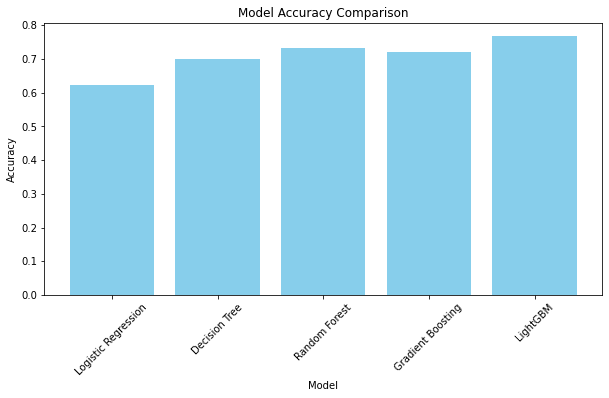

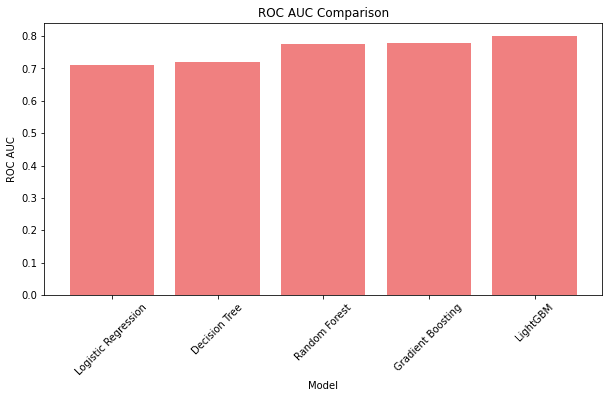

In [131]:
import matplotlib.pyplot as plt

model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "Gradient Boosting", "LightGBM"]
accuracies = [lr_accuracy, dt_accuracy, rf_accuracy, gb_accuracy, lgb_accuracy]
roc_auc_scores = [lr_roc_auc, dt_roc_auc, rf_roc_auc, gb_roc_auc, lgb_roc_auc]

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

# Plot ROC AUC
plt.figure(figsize=(10, 5))
plt.bar(model_names, roc_auc_scores, color='lightcoral')
plt.xlabel('Model')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Comparison')
plt.xticks(rotation=45)
plt.show()


## Using Most Important Features Only

### Logistic Regression

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gregl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gregl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\gregl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Valu

Model: Logistic Regression
Hyperparameters and Cross-Validation Scores:
Hyperparameters: {'C': 0.001, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 0.001, 'penalty': 'l2'}
Mean CV Score: 0.77
Hyperparameters: {'C': 0.01, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 0.01, 'penalty': 'l2'}
Mean CV Score: 0.77
Hyperparameters: {'C': 0.1, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Mean CV Score: 0.77
Hyperparameters: {'C': 1, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 1, 'penalty': 'l2'}
Mean CV Score: 0.77
Hyperparameters: {'C': 10, 'penalty': 'l1'}
Mean CV Score: nan
Hyperparameters: {'C': 10, 'penalty': 'l2'}
Mean CV Score: 0.77
Best Hyperparameters: {'C': 1, 'penalty': 'l2'}
Accuracy: 0.68
Precision: 0.94
Recall: 0.62
F1 Score: 0.75
ROC AUC Score: 0.74
-------------------------


C:\Users\gregl\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


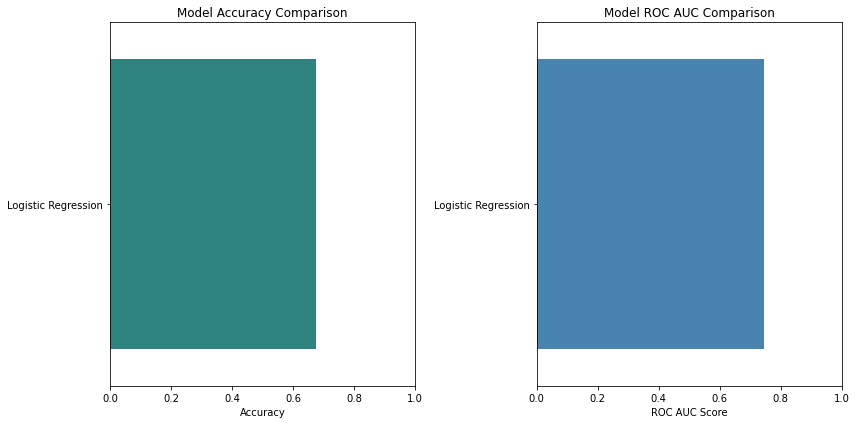

In [12]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
from imblearn.over_sampling import BorderlineSMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import lightgbm as lgb



# Select predictor variables
X = df[['Agency', 'WorkflowStatus','Product','ProductGroup','ProductType','Indexation','NoOfLives' ,
        'UWDecision','CommDateProvided','SignedDecReceived','ComissionSacrifice','CommissionSacrificePercentage',
       'CommissionTerms','BonusCommissionPercentage','SeriousIllnessType']]
y = df['PolicyIssued']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Convert X_train_resampled and X_test back to Pandas DataFrames
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_train.columns)

# Define a list of models to iterate through
models = {
    "Logistic Regression": LogisticRegression()
}

# Define hyperparameter grids for each model
param_grids = {
    "Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 10],
        "penalty": ["l1", "l2"]
    }
}

# Create lists to store the model names, accuracies, and ROC AUC scores
model_names = []
accuracies = []
roc_auc_scores = []

# Create dictionaries to store the best hyperparameters and best models
best_hyperparameters = {}
best_models = {}

# Loop through each model and perform hyperparameter tuning
for name, model in models.items():
    # Define the hyperparameter grid for the current model
    param_grid = param_grids.get(name, {})  # Get the hyperparameter grid or an empty dictionary
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    
    # Fit the model to the data with hyperparameter tuning
    grid_search.fit(X_train_resampled, y_train_resampled)  # Use the resampled data
    
    # Get the best hyperparameters
    best_hyperparameters[name] = grid_search.best_params_
    
    # Get the best model with tuned hyperparameters
    best_model = grid_search.best_estimator_
    
    # Store the best model in the dictionary
    best_models[name] = best_model
    
    # Print the results for each set of hyperparameters
    print(f"Model: {name}")
    print("Hyperparameters and Cross-Validation Scores:")
    for params, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
        print(f"Hyperparameters: {params}")
        print(f"Mean CV Score: {score:.2f}")
    
    # Evaluate the best model's performance
    y_pred = best_model.predict(X_test_scaled)  # Use the scaled test data
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Append the results to the lists
    model_names.append(name)
    accuracies.append(accuracy)
    roc_auc_scores.append(roc_auc)
    
    # Print the results for the best model
    print(f"Best Hyperparameters: {best_hyperparameters[name]}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC Score: {roc_auc:.2f}")
    print("-------------------------")

# Create subplots for model accuracy and ROC AUC visualizations
plt.figure(figsize=(12, 6))

# Model Accuracy Comparison
plt.subplot(1, 2, 1)
sns.barplot(x=accuracies, y=model_names, palette="viridis")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xlim(0, 1.0)  # Set the x-axis limits to accommodate accuracy values

# Model ROC AUC Comparison
plt.subplot(1, 2, 2)
sns.barplot(x=roc_auc_scores, y=model_names, palette="Blues_d")
plt.xlabel("ROC AUC Score")
plt.title("Model ROC AUC Comparison")
plt.xlim(0, 1.0)  # Set the x-axis limits to accommodate ROC AUC values

plt.tight_layout()  
plt.show()


In [133]:
# Select predictor variables
X = df[['Agency', 'WorkflowStatus','Product','ProductGroup','ProductType','Indexation','NoOfLives' ,
        'UWDecision','CommDateProvided','SignedDecReceived','ComissionSacrifice','CommissionSacrificePercentage',
       'CommissionTerms','BonusCommissionPercentage','SeriousIllnessType']]
y = df['PolicyIssued'] 


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test[['Agency', 'WorkflowStatus','Product','ProductGroup','ProductType','Indexation','NoOfLives' ,
        'UWDecision','CommDateProvided','SignedDecReceived','ComissionSacrifice','CommissionSacrificePercentage',
       'CommissionTerms','BonusCommissionPercentage','SeriousIllnessType']]
y_test = df_test['PolicyIssued'] 

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Convert X_train_resampled and X_test back to Pandas DataFrames
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Load the trained Logistic Regression model with the best hyperparameters
best_lr_model = LogisticRegression(C=1, penalty='l2')

# Fit the model to training data
best_lr_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the unseen data
lr_predictions = best_lr_model.predict_proba(X_test)

# Calculate ROC AUC
lr_roc_auc = roc_auc_score(y_test, lr_predictions[:, 1])

# Calculate accuracy
lr_accuracy = accuracy_score(y_test, lr_predictions.argmax(axis=1))

# Calculate precision
lr_precision = precision_score(y_test, lr_predictions.argmax(axis=1))

# Calculate recall
lr_recall = recall_score(y_test, lr_predictions.argmax(axis=1))

# Calculate F1 score
lr_f1 = f1_score(y_test, lr_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", lr_roc_auc)
print("Accuracy:", lr_accuracy)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1 Score:", lr_f1)


ROC AUC: 0.7103186828672243
Accuracy: 0.6123740183766254
Precision: 0.9478172144887399
Recall: 0.5312282994975696
F1 Score: 0.6808544055285064


### Decision Tree and Random Forest

Model: Decision Tree
Hyperparameters and Cross-Validation Scores:
Hyperparameters: {'max_depth': None, 'min_samples_split': 2}
Mean CV Score: 0.83
Hyperparameters: {'max_depth': None, 'min_samples_split': 5}
Mean CV Score: 0.83
Hyperparameters: {'max_depth': None, 'min_samples_split': 10}
Mean CV Score: 0.83
Hyperparameters: {'max_depth': 10, 'min_samples_split': 2}
Mean CV Score: 0.81
Hyperparameters: {'max_depth': 10, 'min_samples_split': 5}
Mean CV Score: 0.81
Hyperparameters: {'max_depth': 10, 'min_samples_split': 10}
Mean CV Score: 0.81
Hyperparameters: {'max_depth': 20, 'min_samples_split': 2}
Mean CV Score: 0.83
Hyperparameters: {'max_depth': 20, 'min_samples_split': 5}
Mean CV Score: 0.83
Hyperparameters: {'max_depth': 20, 'min_samples_split': 10}
Mean CV Score: 0.83
Hyperparameters: {'max_depth': 30, 'min_samples_split': 2}
Mean CV Score: 0.83
Hyperparameters: {'max_depth': 30, 'min_samples_split': 5}
Mean CV Score: 0.83
Hyperparameters: {'max_depth': 30, 'min_samples_split': 

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Model: Random Forest
Hyperparameters and Cross-Validation Scores:
Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Mean CV Score: 0.83
Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Mean CV Score: 0.83
Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Mean CV Score: 0.83
Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Mean CV Score: 0.83
Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Mean CV Score: 0.83
Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Mean CV Score: 0.83
Hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Mean CV Score: 0.83
Hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Mean CV Score: 0.83
Hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}
Mean CV Score: 0.83
Hyperparamete

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Best Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.71
Precision: 0.91
Recall: 0.70
F1 Score: 0.79
ROC AUC Score: 0.72
-------------------------


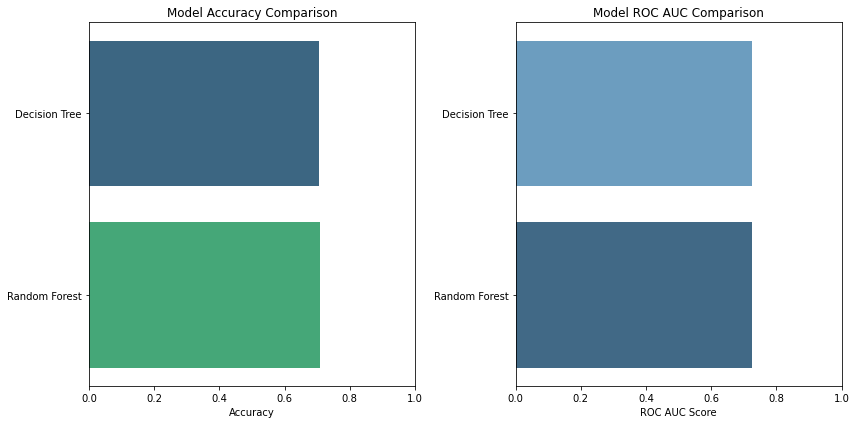

In [13]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
from imblearn.over_sampling import BorderlineSMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import lightgbm as lgb



# Select predictor variables
X = df[['Agency', 'WorkflowStatus']]
y = df['PolicyIssued']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Convert X_train_resampled and X_test back to Pandas DataFrames
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_train.columns)

# Define a list of models to iterate through
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

# Define hyperparameter grids for each model
param_grids = {
    "Decision Tree": {
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10]
    }
}

# Create lists to store the model names, accuracies, and ROC AUC scores
model_names = []
accuracies = []
roc_auc_scores = []

# Create dictionaries to store the best hyperparameters and best models
best_hyperparameters = {}
best_models = {}

# Loop through each model and perform hyperparameter tuning
for name, model in models.items():
    # Define the hyperparameter grid for the current model
    param_grid = param_grids.get(name, {})  # Get the hyperparameter grid or an empty dictionary
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    
    # Fit the model to the data with hyperparameter tuning
    grid_search.fit(X_train_resampled, y_train_resampled)  # Use the resampled data
    
    # Get the best hyperparameters
    best_hyperparameters[name] = grid_search.best_params_
    
    # Get the best model with tuned hyperparameters
    best_model = grid_search.best_estimator_
    
    # Store the best model in the dictionary
    best_models[name] = best_model
    
    # Print the results for each set of hyperparameters
    print(f"Model: {name}")
    print("Hyperparameters and Cross-Validation Scores:")
    for params, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
        print(f"Hyperparameters: {params}")
        print(f"Mean CV Score: {score:.2f}")
    
    # Evaluate the best model's performance
    y_pred = best_model.predict(X_test_scaled)  # Use the scaled test data
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Append the results to the lists
    model_names.append(name)
    accuracies.append(accuracy)
    roc_auc_scores.append(roc_auc)
    
    # Print the results for the best model
    print(f"Best Hyperparameters: {best_hyperparameters[name]}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC Score: {roc_auc:.2f}")
    print("-------------------------")

# Create subplots for model accuracy and ROC AUC visualizations
plt.figure(figsize=(12, 6))

# Model Accuracy Comparison
plt.subplot(1, 2, 1)
sns.barplot(x=accuracies, y=model_names, palette="viridis")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xlim(0, 1.0)  # Set the x-axis limits to accommodate accuracy values

# Model ROC AUC Comparison
plt.subplot(1, 2, 2)
sns.barplot(x=roc_auc_scores, y=model_names, palette="Blues_d")
plt.xlabel("ROC AUC Score")
plt.title("Model ROC AUC Comparison")
plt.xlim(0, 1.0)  # Set the x-axis limits to accommodate ROC AUC values

plt.tight_layout()  
plt.show()


In [134]:
# Select predictor variables
X = df[['Agency', 'WorkflowStatus']]
y = df['PolicyIssued']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test[['Agency', 'WorkflowStatus']]
y_test = df_test['PolicyIssued']  

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Convert X_train_resampled and X_test back to Pandas DataFrames
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Load the trained Decision Tree model with the best hyperparameters
best_dt_model = DecisionTreeClassifier(max_depth=None, min_samples_split=5)

# Fit the model to training data
best_dt_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the unseen data
dt_predictions = best_dt_model.predict_proba(X_test)

# Create a DataFrame with the predictions for further analysis if needed
dt_predictions_df = pd.DataFrame({'Probability_Conversion': dt_predictions[:, 1]})

# Calculate ROC AUC
dt_roc_auc = roc_auc_score(y_test, dt_predictions[:, 1])

# Calculate accuracy
dt_accuracy = accuracy_score(y_test, dt_predictions.argmax(axis=1))

# Calculate precision
dt_precision = precision_score(y_test, dt_predictions.argmax(axis=1))

# Calculate recall
dt_recall = recall_score(y_test, dt_predictions.argmax(axis=1))

# Calculate F1 score
dt_f1 = f1_score(y_test, dt_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", dt_roc_auc)
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1 Score:", dt_f1)


ROC AUC: 0.772188493128829
Accuracy: 0.7077862207102661
Precision: 0.9127524025483209
Recall: 0.6905763653445529
F1 Score: 0.7862707252982349


In [135]:
# Load the trained Random Forest model with the best hyperparameters
best_rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=5)

# Fit the model to training data
best_rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the unseen data
rf_predictions = best_rf_model.predict_proba(X_test)

# Create a DataFrame with the predictions for further analysis if needed
rf_predictions_df = pd.DataFrame({'Probability_Conversion': rf_predictions[:, 1]})

# Calculate ROC AUC
rf_roc_auc = roc_auc_score(y_test, rf_predictions[:, 1])

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions.argmax(axis=1))

# Calculate precision
rf_precision = precision_score(y_test, rf_predictions.argmax(axis=1))

# Calculate recall
rf_recall = recall_score(y_test, rf_predictions.argmax(axis=1))

# Calculate F1 score
rf_f1 = f1_score(y_test, rf_predictions.argmax(axis=1))

# Print or store the evaluation metrics
print("ROC AUC:", rf_roc_auc)
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)


ROC AUC: 0.774143432225579
Accuracy: 0.7080723619368582
Precision: 0.9078210801300848
Recall: 0.6955598219027
F1 Score: 0.787640501410796


### Gradient Boosting Classifier 

Model: Gradient Boosting
Hyperparameters and Cross-Validation Scores:
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Mean CV Score: 0.78
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Mean CV Score: 0.78
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Mean CV Score: 0.79
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
Mean CV Score: 0.79
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
Mean CV Score: 0.79
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
Mean CV Score: 0.79
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Mean CV Score: 0.79
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Mean CV Score: 0.80
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
Mean CV Score: 0.80
Hyperparameters: {'learning_rate': 0.1, 'max_dep

C:\Users\gregl\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


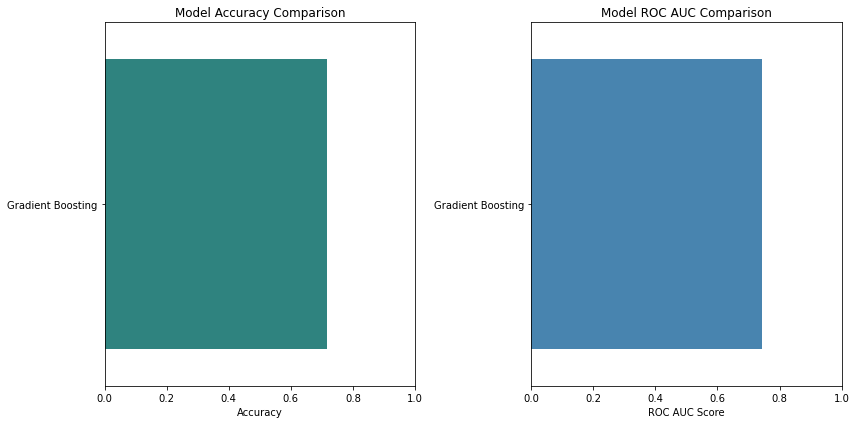

In [15]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
from imblearn.over_sampling import BorderlineSMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import lightgbm as lgb



# Select predictor variables
X = df[['Agency', 'WorkflowStatus','Product','ProductGroup','ProductType','Indexation','NoOfLives' ,
        'UWDecision','CommDateProvided','SignedDecReceived','ComissionSacrifice','CommissionSacrificePercentage',
       'CommissionTerms','BonusCommissionPercentage','SeriousIllnessType']]
y = df['PolicyIssued']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Convert X_train_resampled and X_test back to Pandas DataFrames
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_train.columns)

# Define a list of models to iterate through
models = {
    "Gradient Boosting": GradientBoostingClassifier()
}

# Define hyperparameter grids for each model
param_grids = {
    "Gradient Boosting": {
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 4, 5],
        "learning_rate": [0.01, 0.1, 0.2]
    }
}

# Create lists to store the model names, accuracies, and ROC AUC scores
model_names = []
accuracies = []
roc_auc_scores = []

# Create dictionaries to store the best hyperparameters and best models
best_hyperparameters = {}
best_models = {}

# Loop through each model and perform hyperparameter tuning
for name, model in models.items():
    # Define the hyperparameter grid for the current model
    param_grid = param_grids.get(name, {})  # Get the hyperparameter grid or an empty dictionary
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    
    # Fit the model to the data with hyperparameter tuning
    grid_search.fit(X_train_resampled, y_train_resampled)  # Use the resampled data
    
    # Get the best hyperparameters
    best_hyperparameters[name] = grid_search.best_params_
    
    # Get the best model with tuned hyperparameters
    best_model = grid_search.best_estimator_
    
    # Store the best model in the dictionary
    best_models[name] = best_model
    
    # Print the results for each set of hyperparameters
    print(f"Model: {name}")
    print("Hyperparameters and Cross-Validation Scores:")
    for params, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
        print(f"Hyperparameters: {params}")
        print(f"Mean CV Score: {score:.2f}")
    
    # Evaluate the best model's performance
    y_pred = best_model.predict(X_test_scaled)  # Use the scaled test data
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Append the results to the lists
    model_names.append(name)
    accuracies.append(accuracy)
    roc_auc_scores.append(roc_auc)
    
    # Print the results for the best model
    print(f"Best Hyperparameters: {best_hyperparameters[name]}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC Score: {roc_auc:.2f}")
    print("-------------------------")

# Create subplots for model accuracy and ROC AUC visualizations
plt.figure(figsize=(12, 6))

# Model Accuracy Comparison
plt.subplot(1, 2, 1)
sns.barplot(x=accuracies, y=model_names, palette="viridis")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xlim(0, 1.0)  # Set the x-axis limits to accommodate accuracy values

# Model ROC AUC Comparison
plt.subplot(1, 2, 2)
sns.barplot(x=roc_auc_scores, y=model_names, palette="Blues_d")
plt.xlabel("ROC AUC Score")
plt.title("Model ROC AUC Comparison")
plt.xlim(0, 1.0)  # Set the x-axis limits to accommodate ROC AUC values

plt.tight_layout()  
plt.show()


In [139]:
# Select predictor variables
X = df[['Agency', 'WorkflowStatus','Product','ProductGroup','ProductType','Indexation','NoOfLives' ,
        'UWDecision','CommDateProvided','SignedDecReceived','ComissionSacrifice','CommissionSacrificePercentage',
       'CommissionTerms','BonusCommissionPercentage','SeriousIllnessType']]
y = df['PolicyIssued']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test[['Agency', 'WorkflowStatus','Product','ProductGroup','ProductType','Indexation','NoOfLives' ,
        'UWDecision','CommDateProvided','SignedDecReceived','ComissionSacrifice','CommissionSacrificePercentage',
       'CommissionTerms','BonusCommissionPercentage','SeriousIllnessType']]
y_test = df_test['PolicyIssued']

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Convert X_train_resampled and X_test back to Pandas DataFrames
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_train.columns)

# Load the trained Gradient Boosting Classifier model with the best hyperparameters
best_gb_model = GradientBoostingClassifier(n_estimators=300, max_depth=5, learning_rate=0.2)

# Fit the model to training data
best_gb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the unseen data
gb_predictions = best_gb_model.predict_proba(X_test)

# Create a DataFrame with the predictions for further analysis if needed
gb_predictions_df = pd.DataFrame({'Probability_Conversion': gb_predictions[:, 1]})

# Calculate ROC AUC
gb_roc_auc = roc_auc_score(y_test, gb_predictions[:, 1])

# Calculate accuracy
gb_accuracy = accuracy_score(y_test, gb_predictions.argmax(axis=1))

gb_precision = precision_score(y_test, gb_predictions.argmax(axis=1), zero_division=1)
gb_recall = recall_score(y_test, gb_predictions.argmax(axis=1), zero_division=1)
gb_f1 = f1_score(y_test, gb_predictions.argmax(axis=1), zero_division=1)

# Print or store the evaluation metrics
print("ROC AUC:", gb_roc_auc)
print("Accuracy:", gb_accuracy)
print("Precision:", gb_precision)
print("Recall:", gb_recall)
print("F1 Score:", gb_f1)


ROC AUC: 0.41710802080215686
Accuracy: 0.2216640701999809
Precision: 1.0
Recall: 0.0
F1 Score: 0.0


### LightGBM

Model: LightGBM
Hyperparameters and Cross-Validation Scores:
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Mean CV Score: 0.80
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Mean CV Score: 0.82
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Mean CV Score: 0.83
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
Mean CV Score: 0.81
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
Mean CV Score: 0.83
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
Mean CV Score: 0.84
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Mean CV Score: 0.82
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Mean CV Score: 0.84
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
Mean CV Score: 0.85
Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, '

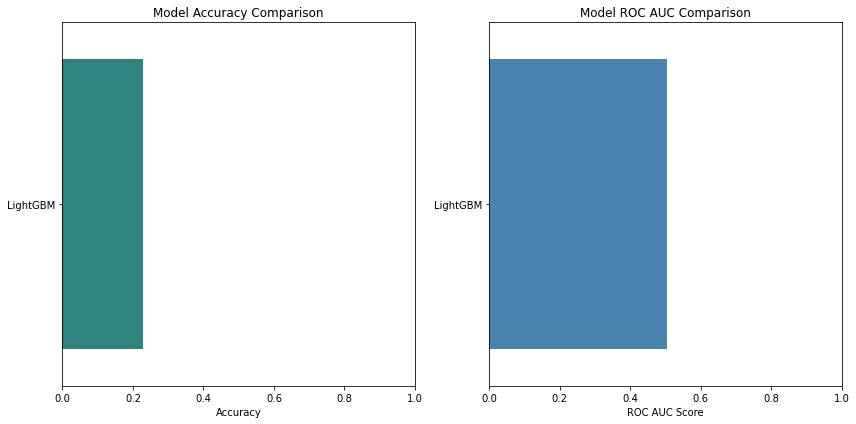

In [17]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
from imblearn.over_sampling import BorderlineSMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import lightgbm as lgb

# Define categorical columns
categorical_columns = ['Agency', 'WorkflowStatus','Product','ProductGroup','ProductType','Indexation','NoOfLives' ,
        'UWDecision','CommDateProvided','SignedDecReceived','ComissionSacrifice',
       'CommissionTerms','SeriousIllnessType']

# Convert categorical columns to categorical data types
df[categorical_columns] = df[categorical_columns].astype('category')

# Select predictor variables
X = df[['Agency', 'WorkflowStatus','Product','ProductGroup','ProductType','Indexation','NoOfLives' ,
        'UWDecision','CommDateProvided','SignedDecReceived','ComissionSacrifice','CommissionSacrificePercentage',
       'CommissionTerms','BonusCommissionPercentage','SeriousIllnessType']]
y = df['PolicyIssued']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Convert X_train_resampled and X_test back to Pandas DataFrames
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_train.columns)

# Reapply categorical transformation to resampled datasets
X_train_resampled[categorical_columns] = X_train_resampled[categorical_columns].astype('category')
X_test[categorical_columns] = X_test[categorical_columns].astype('category')

# Define a list of models to iterate through
models = {
    "LightGBM": lgb.LGBMClassifier()
}

# Define hyperparameter grids for each model
param_grids = {
    "LightGBM": {
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 4, 5],
        "learning_rate": [0.01, 0.1, 0.2]
    }
}

# Create lists to store the model names, accuracies, and ROC AUC scores
model_names = []
accuracies = []
roc_auc_scores = []

# Create dictionaries to store the best hyperparameters and best models
best_hyperparameters = {}
best_models = {}

# Loop through each model and perform hyperparameter tuning
for name, model in models.items():
    # Define the hyperparameter grid for the current model
    param_grid = param_grids.get(name, {})  # Get the hyperparameter grid or an empty dictionary
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    
    # Fit the model to the data with hyperparameter tuning
    grid_search.fit(X_train_resampled, y_train_resampled)  # Use the resampled data
    
    # Get the best hyperparameters
    best_hyperparameters[name] = grid_search.best_params_
    
    # Get the best model with tuned hyperparameters
    best_model = grid_search.best_estimator_
    
    # Store the best model in the dictionary
    best_models[name] = best_model
    
    # Print the results for each set of hyperparameters
    print(f"Model: {name}")
    print("Hyperparameters and Cross-Validation Scores:")
    for params, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
        print(f"Hyperparameters: {params}")
        print(f"Mean CV Score: {score:.2f}")
    
    # Evaluate the best model's performance
    y_pred = best_model.predict(X_test_scaled)  # Use the scaled test data
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Append the results to the lists
    model_names.append(name)
    accuracies.append(accuracy)
    roc_auc_scores.append(roc_auc)
    
    # Print the results for the best model
    print(f"Best Hyperparameters: {best_hyperparameters[name]}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC Score: {roc_auc:.2f}")
    print("-------------------------")

# Create subplots for model accuracy and ROC AUC visualizations
plt.figure(figsize=(12, 6))

# Model Accuracy Comparison
plt.subplot(1, 2, 1)
sns.barplot(x=accuracies, y=model_names, palette="viridis")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xlim(0, 1.0)  # Set the x-axis limits to accommodate accuracy values

# Model ROC AUC Comparison
plt.subplot(1, 2, 2)
sns.barplot(x=roc_auc_scores, y=model_names, palette="Blues_d")
plt.xlabel("ROC AUC Score")
plt.title("Model ROC AUC Comparison")
plt.xlim(0, 1.0)  # Set the x-axis limits to accommodate ROC AUC values

plt.tight_layout()  
plt.show()


In [140]:
# Define categorical columns
categorical_columns = ['Agency', 'WorkflowStatus','Product','ProductGroup','ProductType','Indexation','NoOfLives' ,
        'UWDecision','CommDateProvided','SignedDecReceived','ComissionSacrifice',
       'CommissionTerms','SeriousIllnessType']

# Convert categorical columns to categorical data types
df[categorical_columns] = df[categorical_columns].astype('category')

# Select predictor variables
X = df[['Agency', 'WorkflowStatus','Product','ProductGroup','ProductType','Indexation','NoOfLives' ,
        'UWDecision','CommDateProvided','SignedDecReceived','ComissionSacrifice','CommissionSacrificePercentage',
       'CommissionTerms','BonusCommissionPercentage','SeriousIllnessType']]
y = df['PolicyIssued']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test[['Agency', 'WorkflowStatus','Product','ProductGroup','ProductType','Indexation','NoOfLives' ,
        'UWDecision','CommDateProvided','SignedDecReceived','ComissionSacrifice','CommissionSacrificePercentage',
       'CommissionTerms','BonusCommissionPercentage','SeriousIllnessType']]
y_test = df_test['PolicyIssued']

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Convert X_train_resampled and X_test back to Pandas DataFrames
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_train.columns)

# Reapply categorical transformation to resampled datasets
X_train_resampled[categorical_columns] = X_train_resampled[categorical_columns].astype('category')
X_test[categorical_columns] = X_test[categorical_columns].astype('category')

# Load the trained LightGBM model with the best hyperparameters
best_lightgbm_model = lgb.LGBMClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)

# Fit the model to training data 
best_lightgbm_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the unseen data
lgb_predictions = best_lightgbm_model.predict_proba(X_test)

# Create a DataFrame with the predictions for further analysis if needed
lgb_predictions_df = pd.DataFrame({'Probability_Conversion': lgb_predictions[:, 1]})

# Calculate ROC AUC
lgb_roc_auc = roc_auc_score(y_test, lgb_predictions[:, 1])

# Calculate accuracy
lgb_accuracy = accuracy_score(y_test, lgb_predictions.argmax(axis=1))

# Calculate precision
lgb_precision = precision_score(y_test, lgb_predictions.argmax(axis=1), zero_division=1)

# Calculate recall
lgb_recall = recall_score(y_test, lgb_predictions.argmax(axis=1), zero_division=1)

# Calculate F1 score
lgb_f1 = f1_score(y_test, lgb_predictions.argmax(axis=1), zero_division=1)

# Print or store the evaluation metrics
print("ROC AUC:", lgb_roc_auc)
print("Accuracy:", lgb_accuracy)
print("Precision:", lgb_precision)
print("Recall:",lgb_recall)
print("F1 Score:", lgb_f1)

ROC AUC: 0.5
Accuracy: 0.2216640701999809
Precision: 1.0
Recall: 0.0
F1 Score: 0.0


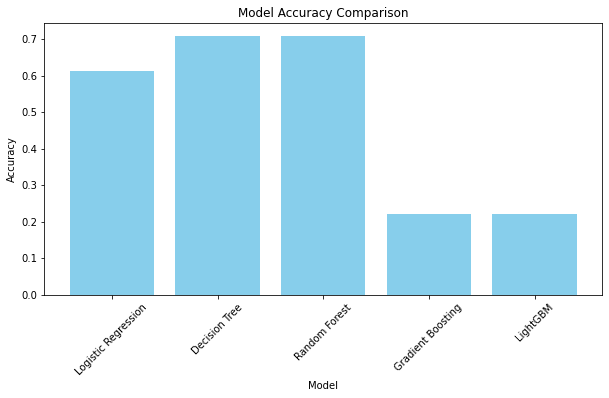

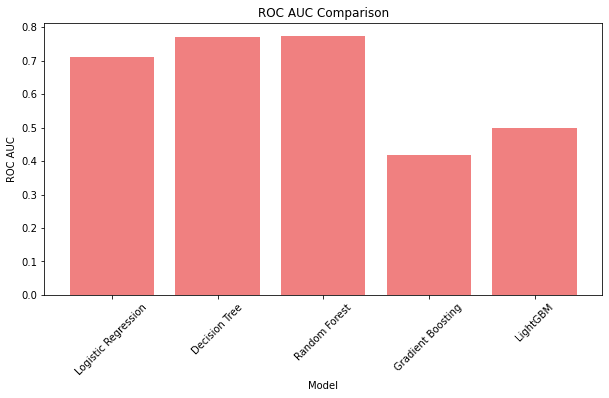

In [141]:
import matplotlib.pyplot as plt

model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "Gradient Boosting", "LightGBM"]
accuracies = [lr_accuracy, dt_accuracy, rf_accuracy, gb_accuracy, lgb_accuracy]
roc_auc_scores = [lr_roc_auc, dt_roc_auc, rf_roc_auc, gb_roc_auc, lgb_roc_auc]

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

# Plot ROC AUC
plt.figure(figsize=(10, 5))
plt.bar(model_names, roc_auc_scores, color='lightcoral')
plt.xlabel('Model')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Comparison')
plt.xticks(rotation=45)
plt.show()
